# EDA

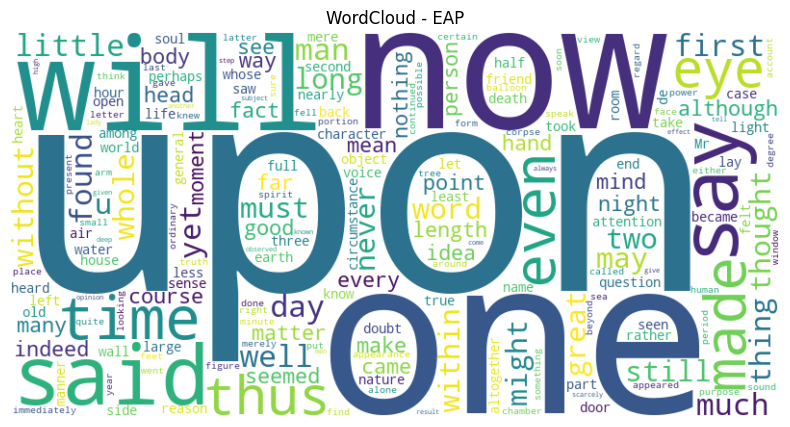

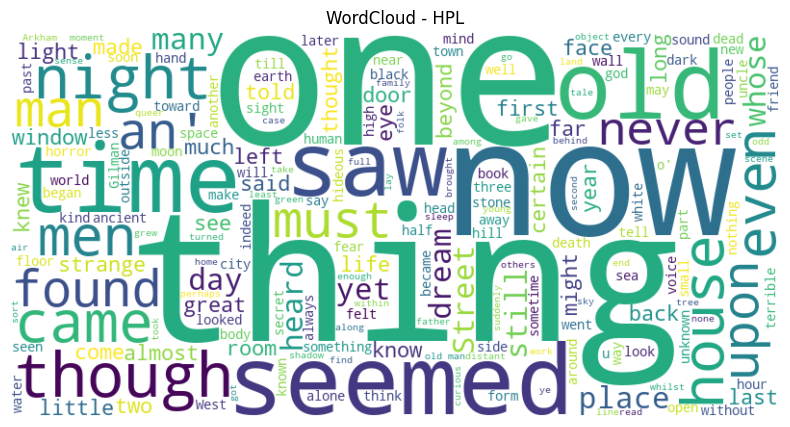

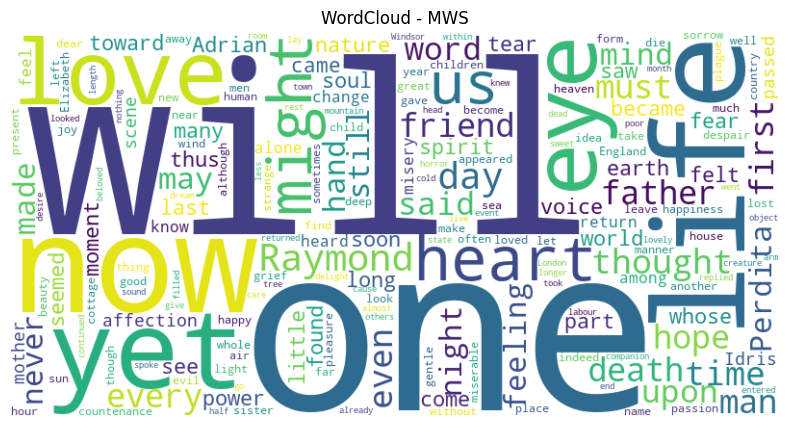

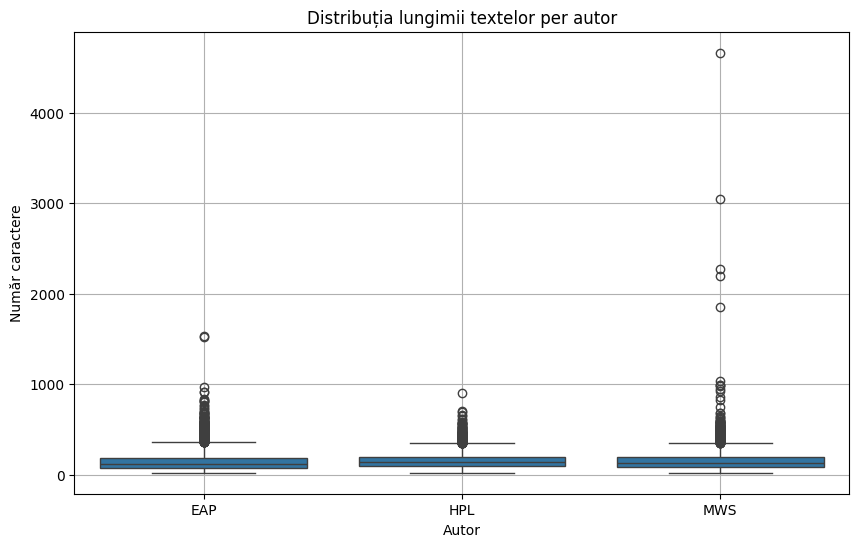

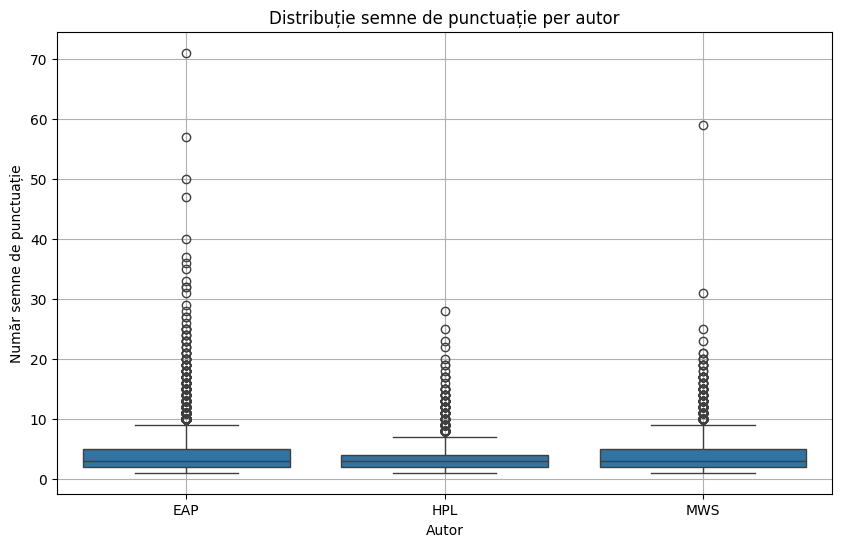

C:\Users\divan\AppData\Local\Temp\ipykernel_17596\1376409913.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_df, x='count', y='word', palette='magma')


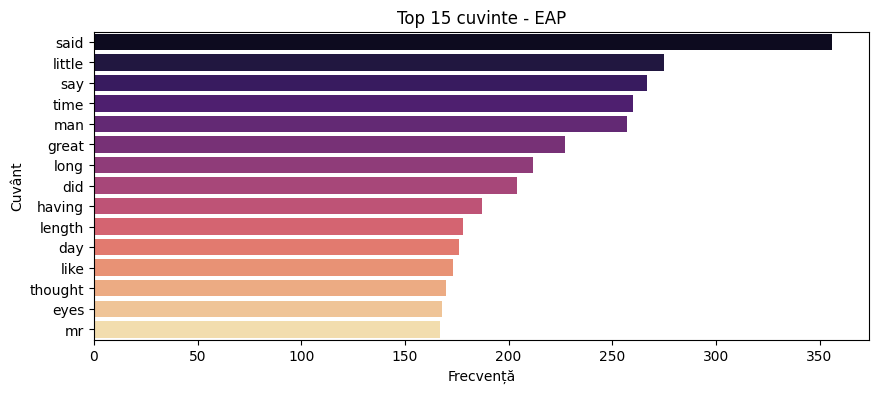

C:\Users\divan\AppData\Local\Temp\ipykernel_17596\1376409913.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_df, x='count', y='word', palette='magma')


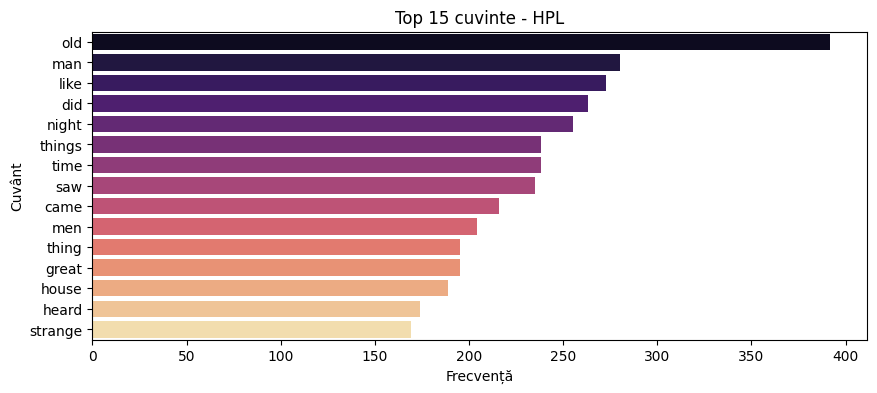

C:\Users\divan\AppData\Local\Temp\ipykernel_17596\1376409913.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_df, x='count', y='word', palette='magma')


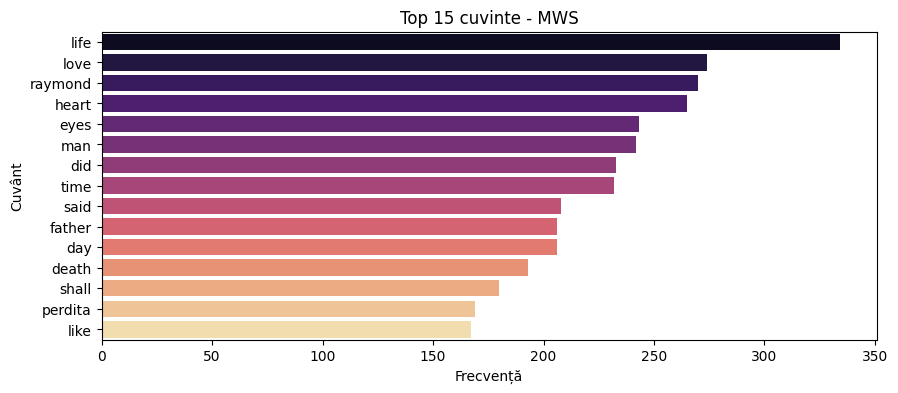

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import string

# Încarcă datele
train_df = pd.read_csv('data/train/train.csv')

# ✅ 1. Wordclouds per autor
authors = train_df['author'].unique()
for author in authors:
    text = " ".join(train_df[train_df['author'] == author]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud - {author}")
    plt.show()

# ✅ 2. Distribuție lungime text per autor
train_df['text_length'] = train_df['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='author', y='text_length')
plt.title('Distribuția lungimii textelor per autor')
plt.ylabel('Număr caractere')
plt.xlabel('Autor')
plt.grid(True)
plt.show()

# ✅ 3. Frecvență semne de punctuație
def count_punctuation(text):
    return sum(1 for c in text if c in string.punctuation)

train_df['punctuation_count'] = train_df['text'].apply(count_punctuation)

plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='author', y='punctuation_count')
plt.title('Distribuție semne de punctuație per autor')
plt.xlabel('Autor')
plt.ylabel('Număr semne de punctuație')
plt.grid(True)
plt.show()

# ✅ 4. Cele mai frecvente cuvinte per autor
from sklearn.feature_extraction.text import CountVectorizer

def top_words(df, author, n=15):
    vec = CountVectorizer(stop_words='english')
    X = vec.fit_transform(df[df['author'] == author]['text'])
    word_counts = X.sum(axis=0).A1
    vocab = vec.get_feature_names_out()
    top_idx = word_counts.argsort()[::-1][:n]
    top_words = [(vocab[i], word_counts[i]) for i in top_idx]
    return pd.DataFrame(top_words, columns=["word", "count"])

for author in authors:
    top_df = top_words(train_df, author)
    plt.figure(figsize=(10, 4))
    sns.barplot(data=top_df, x='count', y='word', palette='magma')
    plt.title(f"Top {len(top_df)} cuvinte - {author}")
    plt.xlabel('Frecvență')
    plt.ylabel('Cuvânt')
    plt.show()


# Preprocesare Text + Feature Engineering

In [1]:
import spacy.cli
spacy.cli.download("en_core_web_sm")


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
import pandas as pd
import numpy as np
import re
import string
import spacy
import nltk
from nltk.corpus import stopwords


# Descarcă stopwords dacă nu sunt deja
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Încarcă datele
train_df = pd.read_csv('data/train/train.csv')
test_df = pd.read_csv('data/test/test.csv')

# Încarcă modelul spaCy engleză
nlp = spacy.load("en_core_web_sm")

# Funcție de curățare + lematizare
def clean_text(text):
    # Remove punctuație și cifre
    text = re.sub(r'[\d{}]+'.format(re.escape(string.punctuation)), '', text)
    # Tokenizare și lematizare
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and not token.is_space]
    return " ".join(tokens)

# Aplica preprocesare pe text (durează câteva minute)
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Feature engineering suplimentar
def extract_features(df):
    df['text_length'] = df['text'].apply(len)
    df['num_words'] = df['text'].apply(lambda x: len(x.split()))
    df['num_capitals'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper()))
    df['capital_ratio'] = df['num_capitals'] / (df['text_length'] + 1e-6)
    df['num_exclaims'] = df['text'].apply(lambda x: x.count('!'))
    df['num_questions'] = df['text'].apply(lambda x: x.count('?'))
    df['num_puncts'] = df['text'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
    return df

train_df = extract_features(train_df)
test_df = extract_features(test_df)

# Afișare preview
print(train_df[['text', 'clean_text', 'text_length', 'num_words', 'capital_ratio']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\divan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                text  \
0  This process, however, afforded me no means of...   
1  It never once occurred to me that the fumbling...   
2  In his left hand was a gold snuff box, from wh...   
3  How lovely is spring As we looked from Windsor...   
4  Finding nothing else, not even gold, the Super...   

                                          clean_text  text_length  num_words  \
0  process however afford I mean ascertain dimens...          231         41   
1          never occur I fumbling might mere mistake           71         14   
2  left hand gold snuff box caper hill cut manner...          200         36   
3  lovely spring look windsor terrace sixteen fer...          206         34   
4  find nothing else even gold superintendent aba...          174         27   

   capital_ratio  
0       0.012987  
1       0.014085  
2       0.005000  
3       0.019417  
4       0.011494  


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

# TF-IDF pe unigrame
tfidf_word = TfidfVectorizer(
    analyzer='word',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=5000
)

# TF-IDF pe bigrame
tfidf_bigram = TfidfVectorizer(
    analyzer='word',
    stop_words='english',
    ngram_range=(2, 2),
    max_features=2000
)

# TF-IDF pe n-gramuri de caractere (bun pentru stil)
tfidf_char = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 5),
    max_features=5000
)

# Combinație între toate
combined_vectorizer = FeatureUnion([
    ('word_uni', tfidf_word),
    ('word_bi', tfidf_bigram),
    ('char_ngram', tfidf_char)
])

# Aplică pe textul curățat
X_text = combined_vectorizer.fit_transform(train_df['clean_text'])
X_test_text = combined_vectorizer.transform(test_df['clean_text'])

print("Dimensiune vectorizată:", X_text.shape)


Dimensiune vectorizată: (19579, 12000)


In [14]:
from scipy.sparse import csr_matrix

X_final = csr_matrix(X_final)
X_test_final = csr_matrix(X_test_final)


NameError: name 'X_final' is not defined

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from scipy.sparse import hstack, csr_matrix
import numpy as np

# Encode target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(train_df['author'])

# Features numerice
X_feats = train_df[['text_length', 'num_words', 'capital_ratio', 'num_exclaims', 'num_questions', 'num_puncts']].values
X_test_feats = test_df[['text_length', 'num_words', 'capital_ratio', 'num_exclaims', 'num_questions', 'num_puncts']].values

# Concatenare sparse + dense
X_final = hstack([X_text, X_feats])
X_test_final = hstack([X_test_text, X_test_feats])

# Convertim la CSR pt slicing
X_final = csr_matrix(X_final)
X_test_final = csr_matrix(X_test_final)

# Cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_losses = []
test_preds = np.zeros((test_df.shape[0], 3))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_final, y)):
    X_train, X_val = X_final[train_idx], X_final[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = LogisticRegression(max_iter=1000, solver='saga', C=1.0)
    model.fit(X_train, y_train)

    val_pred = model.predict_proba(X_val)
    loss = log_loss(y_val, val_pred)
    val_losses.append(loss)
    print(f"Fold {fold+1} - LogLoss: {loss:.4f}")

    test_preds += model.predict_proba(X_test_final) / kf.n_splits

print(f"\n✅ Mean CV LogLoss: {np.mean(val_losses):.4f}")


c:\Projects\kaggle\author\kenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 1 - LogLoss: 1.0617


c:\Projects\kaggle\author\kenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 2 - LogLoss: 1.0551


c:\Projects\kaggle\author\kenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 3 - LogLoss: 1.0604


c:\Projects\kaggle\author\kenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 4 - LogLoss: 1.0633
Fold 5 - LogLoss: 1.0666

✅ Mean CV LogLoss: 1.0614


c:\Projects\kaggle\author\kenv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [9]:
# Construiește dataframe-ul pentru submit
submission = pd.DataFrame(test_preds, columns=le.classes_)
submission.insert(0, 'id', test_df['id'])

# Salvează în format corect
submission.to_csv('submission_logreg.csv', index=False)
print("✅ Fișier salvat: submission_logreg.csv")


✅ Fișier salvat: submission_logreg.csv


In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
import numpy as np

# Refolosim doar TF-IDF fără extra features
X_nb = csr_matrix(X_text)         # already generated earlier
X_nb_test = csr_matrix(X_test_text)
y = le.transform(train_df['author'])

# Cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_losses = []
test_preds_nb = np.zeros((test_df.shape[0], 3))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_nb, y)):
    X_train, X_val = X_nb[train_idx], X_nb[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = MultinomialNB()
    model.fit(X_train, y_train)

    val_pred = model.predict_proba(X_val)
    loss = log_loss(y_val, val_pred)
    val_losses.append(loss)
    print(f"Fold {fold+1} - LogLoss: {loss:.4f}")

    test_preds_nb += model.predict_proba(X_nb_test) / kf.n_splits

print(f"\n✅ Mean CV LogLoss (NB): {np.mean(val_losses):.4f}")


Fold 1 - LogLoss: 0.5529
Fold 2 - LogLoss: 0.5242
Fold 3 - LogLoss: 0.5486
Fold 4 - LogLoss: 0.5272
Fold 5 - LogLoss: 0.5369

✅ Mean CV LogLoss (NB): 0.5380


In [11]:
submission_nb = pd.DataFrame(test_preds_nb, columns=le.classes_)
submission_nb.insert(0, 'id', test_df['id'])
submission_nb.to_csv('submission_naivebayes.csv', index=False)
print("✅ Fișier salvat: submission_naivebayes.csv")


✅ Fișier salvat: submission_naivebayes.csv


In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from scipy.sparse import hstack, csr_matrix
import numpy as np

# Refolosim X_final (TF-IDF + engineered features)
X_final = csr_matrix(X_final)
X_test_final = csr_matrix(X_test_final)
y = le.transform(train_df['author'])

# Setări model
xgb_params = {
    "objective": "multi:softprob",
    "num_class": 3,
    "eval_metric": "mlogloss",
    "use_label_encoder": False,
    "n_estimators": 200,
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "random_state": 42
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_losses = []
test_preds_xgb = np.zeros((test_df.shape[0], 3))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_final, y)):
    X_train, X_val = X_final[train_idx], X_final[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = XGBClassifier(**xgb_params)
    model.fit(X_train, y_train)

    val_pred = model.predict_proba(X_val)
    loss = log_loss(y_val, val_pred)
    val_losses.append(loss)
    print(f"Fold {fold+1} - LogLoss: {loss:.4f}")

    test_preds_xgb += model.predict_proba(X_test_final) / kf.n_splits

print(f"\n✅ Mean CV LogLoss (XGBoost): {np.mean(val_losses):.4f}")


c:\Projects\kaggle\author\kenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:27:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1 - LogLoss: 0.6998


c:\Projects\kaggle\author\kenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:32:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2 - LogLoss: 0.6928


c:\Projects\kaggle\author\kenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:34:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3 - LogLoss: 0.6949


c:\Projects\kaggle\author\kenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:37:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4 - LogLoss: 0.6854


c:\Projects\kaggle\author\kenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 5 - LogLoss: 0.6929

✅ Mean CV LogLoss (XGBoost): 0.6932


In [13]:
submission_xgb = pd.DataFrame(test_preds_xgb, columns=le.classes_)
submission_xgb.insert(0, 'id', test_df['id'])
submission_xgb.to_csv('submission_xgboost.csv', index=False)
print("✅ Fișier salvat: submission_xgboost.csv")


✅ Fișier salvat: submission_xgboost.csv


In [10]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
import numpy as np

# Pregătire date
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
val_losses = []
test_preds_xgb = np.zeros((X_nb_test.shape[0], 3))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_nb, y)):
    print(f"Fold {fold+1}")
    X_train, X_val = X_nb[train_idx], X_nb[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        eval_metric='mlogloss',
        tree_method='hist', # sau 'gpu_hist' dacă ai GPU activat
        n_estimators=250,
        max_depth=6,
        learning_rate=0.12,
        subsample=0.8,
        colsample_bytree=0.7,
        random_state=42,
        use_label_encoder=False
    )
    
    model.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)],
              verbose=20)
    
    val_pred = model.predict_proba(X_val)
    loss = log_loss(y_val, val_pred)
    val_losses.append(loss)
    print(f"Log loss val: {loss:.5f}")
    
    test_preds_xgb += model.predict_proba(X_nb_test) / kf.n_splits

print(f"Mean CV LogLoss (XGBoost): {np.mean(val_losses):.5f}")

# Submission
submission = pd.DataFrame(test_preds_xgb, columns=le.classes_)
submission.insert(0, 'id', test_df['id'])
submission.to_csv('submission_xgb_tfidf.csv', index=False)
print("✅ Fișier salvat: submission_xgb_tfidf.csv")


Fold 1


c:\Projects\kaggle\author\kenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:28:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:1.09219
[20]	validation_0-mlogloss:1.05965
[40]	validation_0-mlogloss:1.06318
[60]	validation_0-mlogloss:1.06685
[80]	validation_0-mlogloss:1.07048
[100]	validation_0-mlogloss:1.07322
[120]	validation_0-mlogloss:1.07475
[140]	validation_0-mlogloss:1.07589
[160]	validation_0-mlogloss:1.08015
[180]	validation_0-mlogloss:1.07930
[200]	validation_0-mlogloss:1.07830
[220]	validation_0-mlogloss:1.07789
[240]	validation_0-mlogloss:1.07823
[249]	validation_0-mlogloss:1.07676
Log loss val: 0.66086
Fold 2


c:\Projects\kaggle\author\kenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:33:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:1.09262
[20]	validation_0-mlogloss:1.06496
[40]	validation_0-mlogloss:1.06919
[60]	validation_0-mlogloss:1.06893
[80]	validation_0-mlogloss:1.07192
[100]	validation_0-mlogloss:1.07462
[120]	validation_0-mlogloss:1.07433
[140]	validation_0-mlogloss:1.07692
[160]	validation_0-mlogloss:1.08004
[180]	validation_0-mlogloss:1.08038
[200]	validation_0-mlogloss:1.07936
[220]	validation_0-mlogloss:1.08041
[240]	validation_0-mlogloss:1.08008
[249]	validation_0-mlogloss:1.08189
Log loss val: 0.65239
Fold 3


c:\Projects\kaggle\author\kenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:37:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:1.09302
[20]	validation_0-mlogloss:1.06511
[40]	validation_0-mlogloss:1.06725
[60]	validation_0-mlogloss:1.06901
[80]	validation_0-mlogloss:1.07330
[100]	validation_0-mlogloss:1.07291
[120]	validation_0-mlogloss:1.07426
[140]	validation_0-mlogloss:1.07427
[160]	validation_0-mlogloss:1.07488
[180]	validation_0-mlogloss:1.07449
[200]	validation_0-mlogloss:1.07639
[220]	validation_0-mlogloss:1.07690
[240]	validation_0-mlogloss:1.07821
[249]	validation_0-mlogloss:1.07925
Log loss val: 0.65077
Fold 4


c:\Projects\kaggle\author\kenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:41:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:1.09317
[20]	validation_0-mlogloss:1.05962
[40]	validation_0-mlogloss:1.06061
[60]	validation_0-mlogloss:1.06435
[80]	validation_0-mlogloss:1.06466
[100]	validation_0-mlogloss:1.06533
[120]	validation_0-mlogloss:1.06481
[140]	validation_0-mlogloss:1.06730
[160]	validation_0-mlogloss:1.06974
[180]	validation_0-mlogloss:1.07036
[200]	validation_0-mlogloss:1.07093
[220]	validation_0-mlogloss:1.07209
[240]	validation_0-mlogloss:1.07206
[249]	validation_0-mlogloss:1.07334
Log loss val: 0.64710
Fold 5


c:\Projects\kaggle\author\kenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:45:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:1.09125
[20]	validation_0-mlogloss:1.05368
[40]	validation_0-mlogloss:1.05383
[60]	validation_0-mlogloss:1.05660
[80]	validation_0-mlogloss:1.05904
[100]	validation_0-mlogloss:1.06025
[120]	validation_0-mlogloss:1.05942
[140]	validation_0-mlogloss:1.06201
[160]	validation_0-mlogloss:1.06227
[180]	validation_0-mlogloss:1.06234
[200]	validation_0-mlogloss:1.06273
[220]	validation_0-mlogloss:1.06382
[240]	validation_0-mlogloss:1.06421
[249]	validation_0-mlogloss:1.06589
Log loss val: 0.65082
Mean CV LogLoss (XGBoost): 0.65239
✅ Fișier salvat: submission_xgb_tfidf.csv


In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd

# X_nb, X_nb_test, y, le, test_df = deja definite

alphas = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
best_alpha = None
best_loss = float('inf')
losses_per_alpha = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for alpha in alphas:
    val_losses = []
    for train_idx, val_idx in kf.split(X_nb, y):
        X_train, X_val = X_nb[train_idx], X_nb[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        model = MultinomialNB(alpha=alpha)
        model.fit(X_train, y_train)
        val_pred = model.predict_proba(X_val)
        loss = log_loss(y_val, val_pred)
        val_losses.append(loss)
    mean_loss = np.mean(val_losses)
    losses_per_alpha.append(mean_loss)
    print(f"Alpha={alpha:.3f} - Mean CV LogLoss: {mean_loss:.5f}")
    if mean_loss < best_loss:
        best_loss = mean_loss
        best_alpha = alpha

print(f"\n✅ Best alpha: {best_alpha} (CV LogLoss: {best_loss:.5f})")

# Retrain pe tot setul cu best_alpha și faceți submission
final_model = MultinomialNB(alpha=best_alpha)
final_model.fit(X_nb, y)
test_pred = final_model.predict_proba(X_nb_test)

submission = pd.DataFrame(test_pred, columns=le.classes_)
submission.insert(0, 'id', test_df['id'])
submission.to_csv('submission_nb_tuned.csv', index=False)
print("✅ Fișier salvat: submission_nb_tuned.csv")


Alpha=0.010 - Mean CV LogLoss: 0.58568
Alpha=0.030 - Mean CV LogLoss: 0.55443
Alpha=0.100 - Mean CV LogLoss: 0.53216
Alpha=0.300 - Mean CV LogLoss: 0.52595
Alpha=1.000 - Mean CV LogLoss: 0.53799
Alpha=3.000 - Mean CV LogLoss: 0.57445
Alpha=10.000 - Mean CV LogLoss: 0.67637

✅ Best alpha: 0.3 (CV LogLoss: 0.52595)
✅ Fișier salvat: submission_nb_tuned.csv


In [18]:
# 1. Imports și citire date (dacă nu ai deja)

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

# (comentează dacă ai deja încărcate datele)
# train_df = pd.read_csv('/kaggle/input/identify-the-author/train.csv')
# test_df = pd.read_csv('/kaggle/input/identify-the-author/test.csv')

# 2. TF-IDF: Word n-grams + Char n-grams, sublinear_tf, features mari

tfidf_word = TfidfVectorizer(
    analyzer='word',
    stop_words='english',
    ngram_range=(1,3),
    max_features=15000,
    sublinear_tf=True
)

tfidf_char = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3,5),
    max_features=7000,
    sublinear_tf=True
)

X_word = tfidf_word.fit_transform(train_df['text'])
X_word_test = tfidf_word.transform(test_df['text'])

X_char = tfidf_char.fit_transform(train_df['text'])
X_char_test = tfidf_char.transform(test_df['text'])

# Concatenare
X_nb = hstack([X_word, X_char])
X_nb_test = hstack([X_word_test, X_char_test])

# 3. Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(train_df['author'])

# 4. Grid search FINE pentru alpha

fine_alphas = np.linspace(0.01, 0.3, 30)  # 30 valori fine între 0.01 și 0.3
best_alpha = None
best_loss = float('inf')
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for alpha in fine_alphas:
    val_losses = []
    for train_idx, val_idx in kf.split(X_nb, y):
        X_train, X_val = X_nb[train_idx], X_nb[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        model = MultinomialNB(alpha=alpha)
        model.fit(X_train, y_train)
        val_pred = model.predict_proba(X_val)
        loss = log_loss(y_val, val_pred)
        val_losses.append(loss)
    mean_loss = np.mean(val_losses)
    print(f"Alpha={alpha:.4f} - Mean CV LogLoss: {mean_loss:.5f}")
    if mean_loss < best_loss:
        best_loss = mean_loss
        best_alpha = alpha

print(f"\n✅ Best fine alpha: {best_alpha:.4f} (CV LogLoss: {best_loss:.5f})")

# 5. Train pe tot setul cu best alpha și submit

final_model = MultinomialNB(alpha=best_alpha)
final_model.fit(X_nb, y)
test_pred = final_model.predict_proba(X_nb_test)

submission = pd.DataFrame(test_pred, columns=le.classes_)
submission.insert(0, 'id', test_df['id'])
submission.to_csv('submission_nb_super_tuned.csv', index=False)
print("✅ Fișier salvat: submission_nb_super_tuned.csv")


Alpha=0.0100 - Mean CV LogLoss: 0.44127
Alpha=0.0200 - Mean CV LogLoss: 0.43069
Alpha=0.0300 - Mean CV LogLoss: 0.42681
Alpha=0.0400 - Mean CV LogLoss: 0.42521
Alpha=0.0500 - Mean CV LogLoss: 0.42468
Alpha=0.0600 - Mean CV LogLoss: 0.42472
Alpha=0.0700 - Mean CV LogLoss: 0.42510
Alpha=0.0800 - Mean CV LogLoss: 0.42569
Alpha=0.0900 - Mean CV LogLoss: 0.42641
Alpha=0.1000 - Mean CV LogLoss: 0.42723
Alpha=0.1100 - Mean CV LogLoss: 0.42809
Alpha=0.1200 - Mean CV LogLoss: 0.42900
Alpha=0.1300 - Mean CV LogLoss: 0.42993
Alpha=0.1400 - Mean CV LogLoss: 0.43087
Alpha=0.1500 - Mean CV LogLoss: 0.43182
Alpha=0.1600 - Mean CV LogLoss: 0.43276
Alpha=0.1700 - Mean CV LogLoss: 0.43371
Alpha=0.1800 - Mean CV LogLoss: 0.43464
Alpha=0.1900 - Mean CV LogLoss: 0.43557
Alpha=0.2000 - Mean CV LogLoss: 0.43649
Alpha=0.2100 - Mean CV LogLoss: 0.43741
Alpha=0.2200 - Mean CV LogLoss: 0.43831
Alpha=0.2300 - Mean CV LogLoss: 0.43920
Alpha=0.2400 - Mean CV LogLoss: 0.44007
Alpha=0.2500 - Mean CV LogLoss: 0.44094


In [19]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Normalize text
def normalize_text(s):
    s = s.lower()
    s = s.replace('“', '"').replace('”', '"').replace('’', "'").replace('–', '-').replace('—', '-')
    s = re.sub(r'\d+', ' ', s)
    s = re.sub(r'\s+', ' ', s)
    return s.strip()

train_df['text_clean'] = train_df['text'].apply(normalize_text)
test_df['text_clean'] = test_df['text'].apply(normalize_text)

# Word n-grams
tfidf_word = TfidfVectorizer(
    analyzer='word',
    stop_words='english',
    ngram_range=(1, 3),
    max_features=15000,
    min_df=2,
    sublinear_tf=True
)
X_word = tfidf_word.fit_transform(train_df['text_clean'])
X_word_test = tfidf_word.transform(test_df['text_clean'])

# Char_wb n-grams
tfidf_char = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3, 6),
    max_features=8000,
    sublinear_tf=True
)
X_char = tfidf_char.fit_transform(train_df['text_clean'])
X_char_test = tfidf_char.transform(test_df['text_clean'])

# Char n-grams simple
tfidf_char_plain = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 6),
    max_features=4000,
    sublinear_tf=True
)
X_char_plain = tfidf_char_plain.fit_transform(train_df['text_clean'])
X_char_plain_test = tfidf_char_plain.transform(test_df['text_clean'])

# Concatenare finală
from scipy.sparse import hstack
X_final = hstack([X_word, X_char, X_char_plain])
X_test_final = hstack([X_word_test, X_char_test, X_char_plain_test])

# Label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(train_df['author'])

# Grid search foarte fin pentru alpha
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

alphas = np.linspace(0.01, 0.25, 50)
best_alpha = None
best_loss = float('inf')
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for alpha in alphas:
    val_losses = []
    for train_idx, val_idx in kf.split(X_final, y):
        X_train, X_val = X_final[train_idx], X_final[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        model = MultinomialNB(alpha=alpha)
        model.fit(X_train, y_train)
        val_pred = model.predict_proba(X_val)
        loss = log_loss(y_val, val_pred)
        val_losses.append(loss)
    mean_loss = np.mean(val_losses)
    print(f"Alpha={alpha:.4f} - Mean CV LogLoss: {mean_loss:.5f}")
    if mean_loss < best_loss:
        best_loss = mean_loss
        best_alpha = alpha

print(f"\n✅ Best alpha: {best_alpha:.4f} (CV LogLoss: {best_loss:.5f})")

# Train pe tot setul și submission
final_model = MultinomialNB(alpha=best_alpha)
final_model.fit(X_final, y)
test_pred = final_model.predict_proba(X_test_final)

submission = pd.DataFrame(test_pred, columns=le.classes_)
submission.insert(0, 'id', test_df['id'])
submission.to_csv('submission_nb_ultra_tuned.csv', index=False)
print("✅ Fișier salvat: submission_nb_ultra_tuned.csv")


Alpha=0.0100 - Mean CV LogLoss: 0.50472
Alpha=0.0149 - Mean CV LogLoss: 0.50099
Alpha=0.0198 - Mean CV LogLoss: 0.49920
Alpha=0.0247 - Mean CV LogLoss: 0.49835
Alpha=0.0296 - Mean CV LogLoss: 0.49800
Alpha=0.0345 - Mean CV LogLoss: 0.49797
Alpha=0.0394 - Mean CV LogLoss: 0.49813
Alpha=0.0443 - Mean CV LogLoss: 0.49842
Alpha=0.0492 - Mean CV LogLoss: 0.49880
Alpha=0.0541 - Mean CV LogLoss: 0.49924
Alpha=0.0590 - Mean CV LogLoss: 0.49973
Alpha=0.0639 - Mean CV LogLoss: 0.50024
Alpha=0.0688 - Mean CV LogLoss: 0.50077
Alpha=0.0737 - Mean CV LogLoss: 0.50132
Alpha=0.0786 - Mean CV LogLoss: 0.50187
Alpha=0.0835 - Mean CV LogLoss: 0.50243
Alpha=0.0884 - Mean CV LogLoss: 0.50298
Alpha=0.0933 - Mean CV LogLoss: 0.50354
Alpha=0.0982 - Mean CV LogLoss: 0.50409
Alpha=0.1031 - Mean CV LogLoss: 0.50464
Alpha=0.1080 - Mean CV LogLoss: 0.50518
Alpha=0.1129 - Mean CV LogLoss: 0.50571
Alpha=0.1178 - Mean CV LogLoss: 0.50624
Alpha=0.1227 - Mean CV LogLoss: 0.50677
Alpha=0.1276 - Mean CV LogLoss: 0.50728


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd

# (dacă nu ai deja)
# train_df = pd.read_csv('/kaggle/input/identify-the-author/train.csv')
# test_df = pd.read_csv('/kaggle/input/identify-the-author/test.csv')

tfidf = TfidfVectorizer(
    analyzer='word',
    stop_words='english',
    ngram_range=(1,2),
    max_features=10000,
    sublinear_tf=True
)

X_train = tfidf.fit_transform(train_df['text'])
X_test = tfidf.transform(test_df['text'])

le = LabelEncoder()
y = le.fit_transform(train_df['author'])

# Tuning foarte fin alpha!
alphas = np.linspace(0.01, 0.5, 50)
best_alpha = None
best_loss = float('inf')
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for alpha in alphas:
    val_losses = []
    for train_idx, val_idx in kf.split(X_train, y):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        model = MultinomialNB(alpha=alpha)
        model.fit(X_tr, y_tr)
        val_pred = model.predict_proba(X_val)
        loss = log_loss(y_val, val_pred)
        val_losses.append(loss)
    mean_loss = np.mean(val_losses)
    print(f"Alpha={alpha:.4f} - Mean CV LogLoss: {mean_loss:.5f}")
    if mean_loss < best_loss:
        best_loss = mean_loss
        best_alpha = alpha

print(f"\n✅ Best alpha: {best_alpha:.4f} (CV LogLoss: {best_loss:.5f})")

# Train pe tot setul cu best alpha
final_model = MultinomialNB(alpha=best_alpha)
final_model.fit(X_train, y)
test_pred = final_model.predict_proba(X_test)

submission = pd.DataFrame(test_pred, columns=le.classes_)
submission.insert(0, 'id', test_df['id'])
submission.to_csv('submission_nb_best_simple.csv', index=False)
print("✅ Fișier salvat: submission_nb_best_simple.csv")


Alpha=0.0100 - Mean CV LogLoss: 0.46566
Alpha=0.0200 - Mean CV LogLoss: 0.45578
Alpha=0.0300 - Mean CV LogLoss: 0.45259
Alpha=0.0400 - Mean CV LogLoss: 0.45174
Alpha=0.0500 - Mean CV LogLoss: 0.45199
Alpha=0.0600 - Mean CV LogLoss: 0.45286
Alpha=0.0700 - Mean CV LogLoss: 0.45409
Alpha=0.0800 - Mean CV LogLoss: 0.45555
Alpha=0.0900 - Mean CV LogLoss: 0.45717
Alpha=0.1000 - Mean CV LogLoss: 0.45888
Alpha=0.1100 - Mean CV LogLoss: 0.46066
Alpha=0.1200 - Mean CV LogLoss: 0.46248
Alpha=0.1300 - Mean CV LogLoss: 0.46433
Alpha=0.1400 - Mean CV LogLoss: 0.46619
Alpha=0.1500 - Mean CV LogLoss: 0.46807
Alpha=0.1600 - Mean CV LogLoss: 0.46994
Alpha=0.1700 - Mean CV LogLoss: 0.47181
Alpha=0.1800 - Mean CV LogLoss: 0.47368
Alpha=0.1900 - Mean CV LogLoss: 0.47553
Alpha=0.2000 - Mean CV LogLoss: 0.47738
Alpha=0.2100 - Mean CV LogLoss: 0.47921
Alpha=0.2200 - Mean CV LogLoss: 0.48103
Alpha=0.2300 - Mean CV LogLoss: 0.48283
Alpha=0.2400 - Mean CV LogLoss: 0.48462
Alpha=0.2500 - Mean CV LogLoss: 0.48640
